In [4]:
import sys
!{sys.executable} -m pip install ultralytics opencv-python matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import ultralytics
import os
import shutil
import random
import yaml
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO

ultralytics.checks()

Ultralytics 8.3.159 🚀 Python-3.13.5 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7805MiB)
Setup complete ✅ (12 CPUs, 30.9 GB RAM, 198.2/227.8 GB disk)


In [6]:
# Import class names from existing YAML file
def load_class_names_from_yaml(yaml_path):
    """Load class names from existing data.yaml file."""
    if os.path.exists(yaml_path):
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        class_names = data.get('names', [])
        if isinstance(class_names, dict):
            # If names is a dictionary (class_id: class_name), convert to list
            class_names = [class_names[i] for i in sorted(class_names.keys())]
        elif isinstance(class_names, list):
            # If names is already a list, use as is
            pass
        else:
            raise ValueError("Class names in YAML should be either a list or dictionary")

        # Validate class names
        if not class_names:
            raise ValueError("No class names found in YAML file")

        # Check for valid class names (no empty strings)
        class_names = [str(name).strip() for name in class_names if str(name).strip()]

        print(f"Loaded {len(class_names)} class names from {yaml_path}")
        print(f"Classes: {class_names}")
        return class_names
    else:
        raise FileNotFoundError(f"YAML file not found: {yaml_path}")

def validate_yaml_structure(yaml_path):
    """Validate the structure of YAML file for YOLOv8 compatibility."""
    try:
        with open(yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        required_keys = ['names']
        optional_keys = ['path', 'train', 'val', 'test', 'nc']

        missing_keys = [key for key in required_keys if key not in data]
        if missing_keys:
            print(f"Warning: Missing required keys in YAML: {missing_keys}")

        present_keys = [key for key in optional_keys if key in data]
        print(f"Present optional keys: {present_keys}")

        # Validate nc matches number of names
        if 'nc' in data and 'names' in data:
            names = data['names']
            if isinstance(names, list):
                expected_nc = len(names)
            elif isinstance(names, dict):
                expected_nc = len(names)
            else:
                expected_nc = 0

            if data['nc'] != expected_nc:
                print(f"Warning: 'nc' ({data['nc']}) doesn't match number of class names ({expected_nc})")

        return True
    except Exception as e:
        print(f"Error validating YAML: {e}")
        return False

# Dataset configuration
DATASET_PATH = "data/YOLO-Bulk"  # dataset path
OUTPUT_PATH = "yolo_dataset_split"
YAML_CONFIG_PATH = "data/YOLO-Bulk/data.yaml"  # Path to data.yaml 

# Load class names from YAML file
try:
    # First validate the YAML structure
    if os.path.exists(YAML_CONFIG_PATH):
        print("Validating YAML file structure...")
        validate_yaml_structure(YAML_CONFIG_PATH)

    CLASS_NAMES = load_class_names_from_yaml(YAML_CONFIG_PATH)
except FileNotFoundError:
    print(f"Error: {YAML_CONFIG_PATH} not found.")
    os.abort()
except Exception as e:
    print(f"Error loading YAML: {e}")
    os.abort()

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Training configuration
MODEL_SIZE = "yolov8n.pt"  # other yolov8 options exist
EPOCHS = 500
IMAGE_SIZE = 640
BATCH_SIZE = 16

print(f"Train: {TRAIN_RATIO*100}%, Val: {VAL_RATIO*100}%, Test: {TEST_RATIO*100}%")
print(f"Number of classes: {len(CLASS_NAMES)}")

Validating YAML file structure...
Present optional keys: ['nc']
Loaded 26 class names from data/YOLO-Bulk/data.yaml
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Train: 70.0%, Val: 15.0%, Test: 15.0%
Number of classes: 26


In [7]:
def inspect_yaml_file(yaml_path):
    """Inspect and display the contents of a YAML configuration file."""
    if not os.path.exists(yaml_path):
        print(f"YAML file not found: {yaml_path}")
        return None

    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    print("YAML File Contents:")
    print("=" * 50)
    for key, value in data.items():
        print(f"{key}: {value}")

    return data


# Inspect existing YAML file
print("Checking data.yaml...")
if os.path.exists(YAML_CONFIG_PATH):
    yaml_data = inspect_yaml_file(YAML_CONFIG_PATH)
    print("\nValidating YAML structure...")
    validate_yaml_structure(YAML_CONFIG_PATH)
else:
    print(f"YAML file '{YAML_CONFIG_PATH}' not found.")
    print("Expected location: /data/YOLO-Bulk/data.yaml")

Checking data.yaml...
YAML File Contents:
nc: 26
names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
roboflow: {'workspace': 'david-lee-d0rhs', 'project': 'american-sign-language-letters', 'version': 1, 'license': 'Public Domain', 'url': 'https://universe.roboflow.com/david-lee-d0rhs/american-sign-language-letters/dataset/1'}

Validating YAML structure...
Present optional keys: ['nc']


In [8]:
def analyze_dataset(dataset_path):
    """Analyze the original dataset structure and content."""
    print("Dataset Analysis:")
    print("=" * 50)

    images_path = os.path.join(dataset_path, "images")
    labels_path = os.path.join(dataset_path, "labels")

    if not os.path.exists(images_path) or not os.path.exists(labels_path):
        print("Error: Expected 'images' and 'labels' folders in dataset path")
        return False

    # Count files
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    label_files = [f for f in os.listdir(labels_path) if f.lower().endswith('.txt')]

    print(f"Images found: {len(image_files)}")
    print(f"Labels found: {len(label_files)}")

    # Check for matching files
    image_names = {os.path.splitext(f)[0] for f in image_files}
    label_names = {os.path.splitext(f)[0] for f in label_files}

    matched = len(image_names.intersection(label_names))
    unmatched_images = len(image_names - label_names)
    unmatched_labels = len(label_names - image_names)

    print(f"Matched image-label pairs: {matched}")
    print(f"Images without labels: {unmatched_images}")
    print(f"Labels without images: {unmatched_labels}")

    return True

# Analyze the dataset
analyze_dataset(DATASET_PATH)

Dataset Analysis:
Images found: 1728
Labels found: 1728
Matched image-label pairs: 1728
Images without labels: 0
Labels without images: 0


True

In [9]:
def create_directory_structure(output_path):
    """Create the directory structure for train/val/test splits."""
    splits = ['train', 'val', 'test']

    for split in splits:
        os.makedirs(os.path.join(output_path, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_path, split, 'labels'), exist_ok=True)

    print(f"Created directory structure at: {output_path}")

def get_matched_files(dataset_path):
    """Get list of files that have both image and label."""
    images_path = os.path.join(dataset_path, "images")
    labels_path = os.path.join(dataset_path, "labels")

    if not os.path.exists(images_path) or not os.path.exists(labels_path):
        raise FileNotFoundError(f"Images or labels directory not found in {dataset_path}")

    # Get all image files with multiple extensions
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')
    image_files = []
    for ext in image_extensions:
        image_files.extend([f for f in os.listdir(images_path) if f.lower().endswith(ext)])

    print(f"Found {len(image_files)} image files")

    # Filter to only those with corresponding labels
    matched_files = []
    missing_labels = []

    for img_file in image_files:
        base_name = os.path.splitext(img_file)[0]
        label_file = base_name + '.txt'

        img_path = os.path.join(images_path, img_file)
        label_path = os.path.join(labels_path, label_file)

        if os.path.exists(label_path):
            matched_files.append((img_path, label_path, base_name, img_file))
        else:
            missing_labels.append(img_file)

    if missing_labels:
        print(f"Warning: {len(missing_labels)} images don't have corresponding labels")
        if len(missing_labels) <= 10:
            print(f"Missing labels for: {missing_labels}")
        else:
            print(f"First 10 missing labels: {missing_labels[:10]}")

    print(f"Matched image-label pairs: {len(matched_files)}")
    return matched_files

def split_dataset(matched_files, train_ratio, val_ratio, test_ratio):
    """Split the dataset into train/val/test sets."""
    random.shuffle(matched_files)

    total_files = len(matched_files)
    train_count = int(total_files * train_ratio)
    val_count = int(total_files * val_ratio)

    train_files = matched_files[:train_count]
    val_files = matched_files[train_count:train_count + val_count]
    test_files = matched_files[train_count + val_count:]

    print(f"Split summary:")
    print(f"Train: {len(train_files)} files ({len(train_files)/total_files*100:.1f}%)")
    print(f"Val: {len(val_files)} files ({len(val_files)/total_files*100:.1f}%)")
    print(f"Test: {len(test_files)} files ({len(test_files)/total_files*100:.1f}%)")

    return train_files, val_files, test_files

def copy_files(file_list, output_path, split_name):
    """Copy files to the appropriate split directory."""
    for img_path, label_path, base_name, img_filename in file_list:
        # Copy image (preserve original extension)
        img_ext = os.path.splitext(img_filename)[1]
        new_img_path = os.path.join(output_path, split_name, 'images', base_name + img_ext)
        shutil.copy2(img_path, new_img_path)

        # Copy label
        new_label_path = os.path.join(output_path, split_name, 'labels', base_name + '.txt')
        shutil.copy2(label_path, new_label_path)

    print(f"Copied {len(file_list)} files to {split_name} split")

In [10]:
create_directory_structure(OUTPUT_PATH)

matched_files = get_matched_files(DATASET_PATH)

if len(matched_files) == 0:
    print("Error: No matched image-label pairs found!")
    print("Please check that:")
    print("1. Images are in /data/YOLO-Bulk/images/")
    print("2. Labels are in /data/YOLO-Bulk/labels/")
    print("3. Image and label files have matching names (except extensions)")
else:
    print(f"Ready to split {len(matched_files)} matched image-label pairs")

    # Split the dataset
    train_files, val_files, test_files = split_dataset(
        matched_files, TRAIN_RATIO, VAL_RATIO, TEST_RATIO
    )

    # Copy files to respective directories
    copy_files(train_files, OUTPUT_PATH, 'train')
    copy_files(val_files, OUTPUT_PATH, 'val')
    copy_files(test_files, OUTPUT_PATH, 'test')

    print("\n" + "="*50)
    print("DATASET SPLIT COMPLETED SUCCESSFULLY!")
    print("="*50)
    print(f"Original dataset: {DATASET_PATH}")
    print(f"Split dataset: {OUTPUT_PATH}")
    print(f"Total files processed: {len(matched_files)}")

Created directory structure at: yolo_dataset_split
Found 1728 image files
Matched image-label pairs: 1728
Ready to split 1728 matched image-label pairs
Split summary:
Train: 1209 files (70.0%)
Val: 259 files (15.0%)
Test: 260 files (15.0%)
Copied 1209 files to train split
Copied 259 files to val split
Copied 260 files to test split

DATASET SPLIT COMPLETED SUCCESSFULLY!
Original dataset: data/YOLO-Bulk
Split dataset: yolo_dataset_split
Total files processed: 1728


In [11]:
def create_yaml_config(output_path, class_names, base_yaml_path=None):
    """Create YAML configuration file for YOLOv8."""
    # Start with base configuration if provided
    config = {}
    if base_yaml_path and os.path.exists(base_yaml_path):
        with open(base_yaml_path, 'r') as f:
            config = yaml.safe_load(f) or {}
        print(f"Using base configuration from: {base_yaml_path}")

    # Update with new paths and class information
    config.update({
        'path': os.path.abspath(output_path),
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': len(class_names),
        'names': class_names
    })

    yaml_path = os.path.join(output_path, 'dataset.yaml')

    with open(yaml_path, 'w') as f:
        yaml.dump(config, f)

    print(f"Created YAML config at: {yaml_path}")
    return yaml_path

# Create YAML configuration, optionally using existing YAML as base
yaml_config_path = create_yaml_config(OUTPUT_PATH, CLASS_NAMES, YAML_CONFIG_PATH if os.path.exists(YAML_CONFIG_PATH) else None)

# Display the config
with open(yaml_config_path, 'r') as f:
    print("\nDataset configuration:")
    print(f.read())

Using base configuration from: data/YOLO-Bulk/data.yaml
Created YAML config at: yolo_dataset_split/dataset.yaml

Dataset configuration:
names:
- A
- B
- C
- D
- E
- F
- G
- H
- I
- J
- K
- L
- M
- N
- O
- P
- Q
- R
- S
- T
- U
- V
- W
- X
- Y
- Z
nc: 26
path: /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split
roboflow:
  license: Public Domain
  project: american-sign-language-letters
  url: https://universe.roboflow.com/david-lee-d0rhs/american-sign-language-letters/dataset/1
  version: 1
  workspace: david-lee-d0rhs
test: test/images
train: train/images
val: val/images




Sample images from train set:


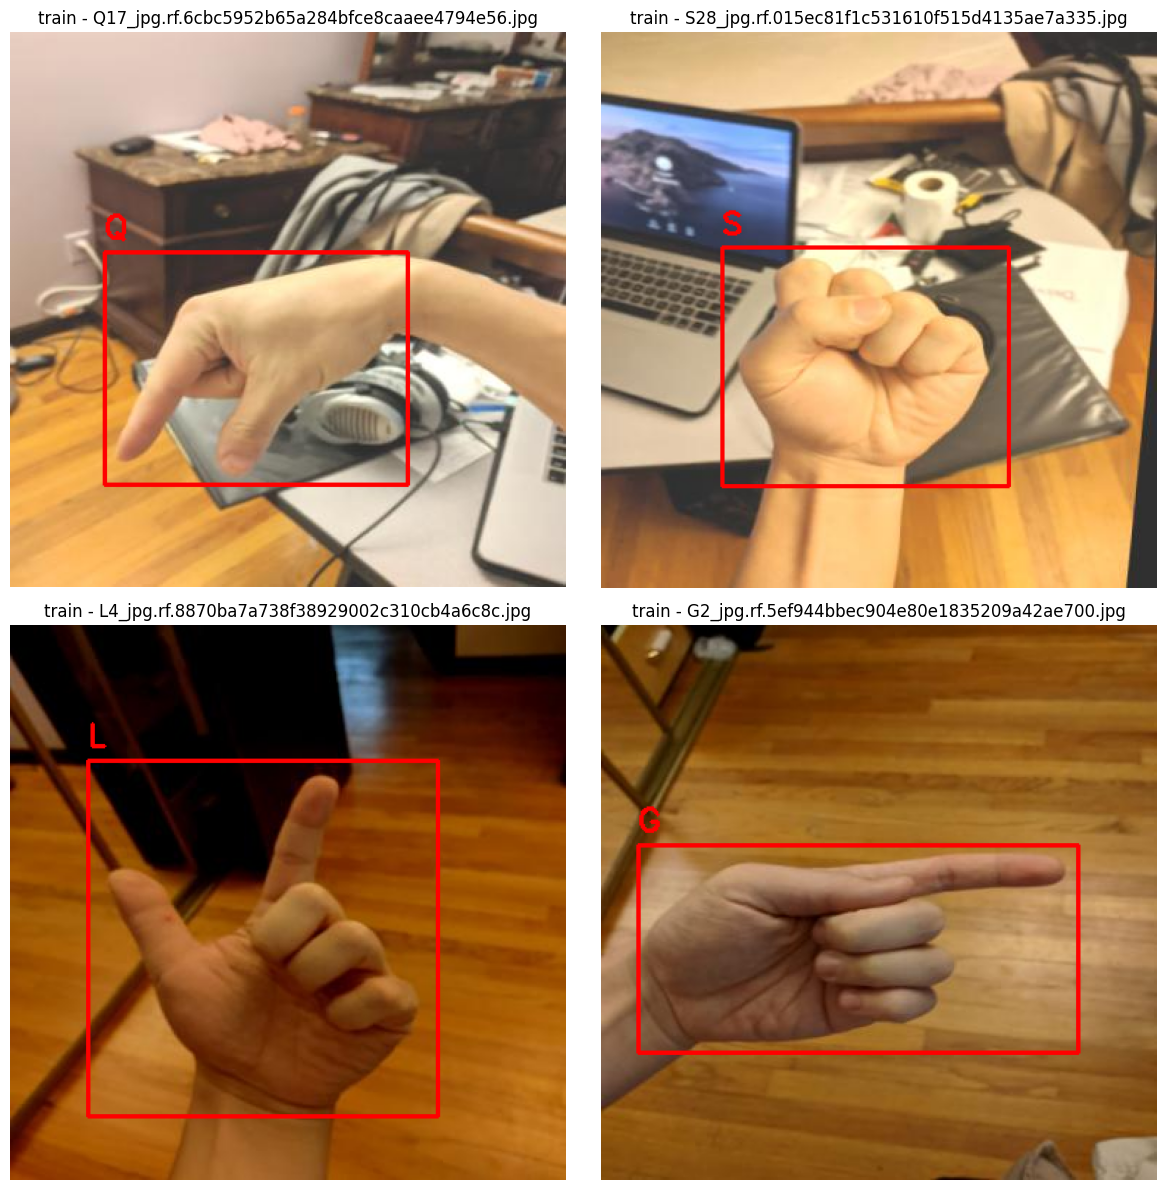


Sample images from val set:


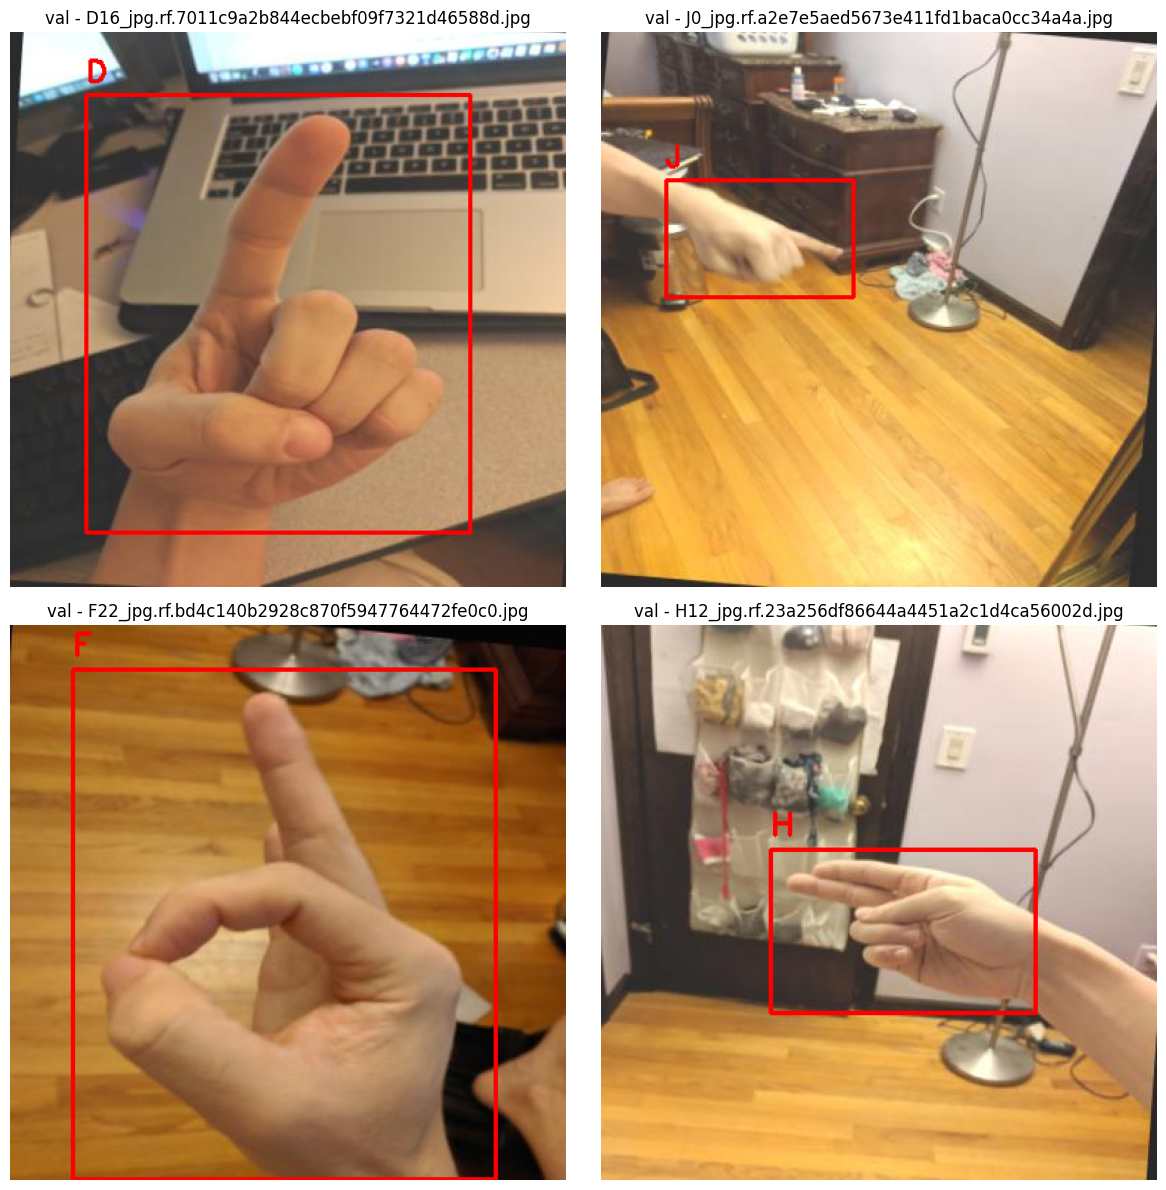


Sample images from test set:


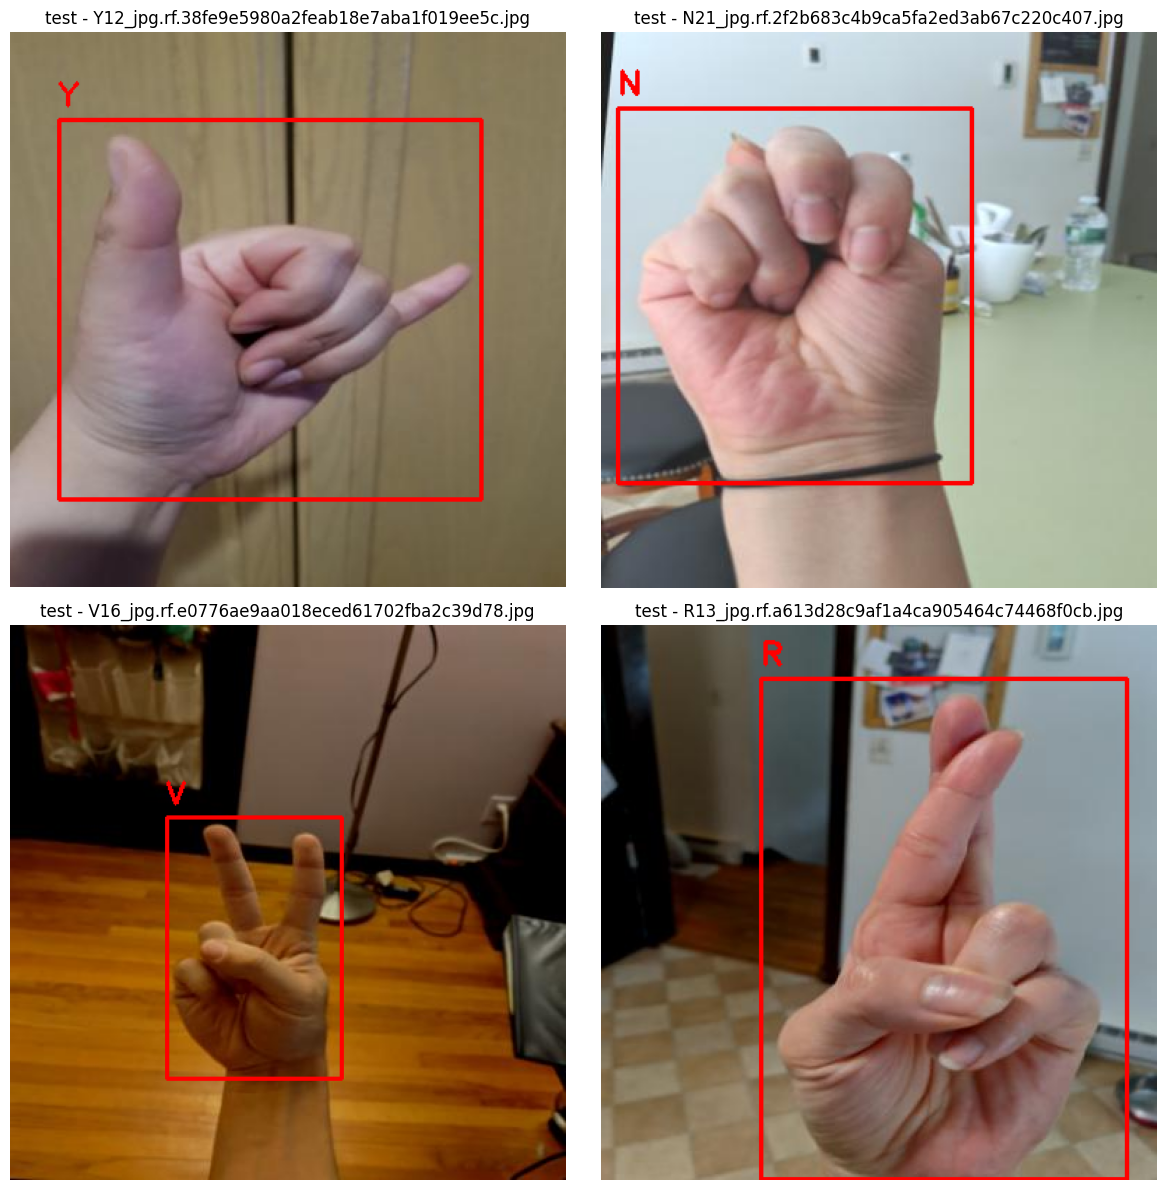

In [12]:
def visualize_samples(output_path, split='train', num_samples=4):
    """Visualize sample images with their annotations."""
    images_dir = os.path.join(output_path, split, 'images')
    labels_dir = os.path.join(output_path, split, 'labels')

    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.ravel()

    for idx, img_file in enumerate(sample_files):
        if idx >= 4:
            break

        # Load image
        img_path = os.path.join(images_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        # Load annotations
        base_name = os.path.splitext(img_file)[0]
        label_path = os.path.join(labels_dir, base_name + '.txt')

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width, height = map(float, parts)

                    # Convert to pixel coordinates
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h

                    # Draw bounding box
                    x1 = int(x_center - width/2)
                    y1 = int(y_center - height/2)
                    x2 = int(x_center + width/2)
                    y2 = int(y_center + height/2)

                    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

                    # Add class label
                    if int(class_id) < len(CLASS_NAMES):
                        label = CLASS_NAMES[int(class_id)]
                        cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

        axes[idx].imshow(image)
        axes[idx].set_title(f'{split} - {img_file}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples from each split
for split in ['train', 'val', 'test']:
    print(f"\nSample images from {split} set:")
    visualize_samples(OUTPUT_PATH, split)

In [13]:
def train_yolo_model(yaml_config_path, model_size, epochs, image_size, batch_size):
    """Train YOLOv8 model."""
    print(f"Starting training with {model_size}")
    print(f"Configuration: epochs={epochs}, image_size={image_size}, batch_size={batch_size}")

    # Load model
    model = YOLO(model_size)

    # Train the model
    results = model.train(
        data=yaml_config_path,
        epochs=epochs,
        imgsz=image_size,
        batch=batch_size,
        save=True,
        project='ASL-fingerspelling',
        name='asl-model',
        exist_ok=True, # overwrite
        patience=20,
        save_period=10
    )

    return model, results

# Start training
print("Initializing model training...")
model, training_results = train_yolo_model(
    yaml_config_path, MODEL_SIZE, EPOCHS, IMAGE_SIZE, BATCH_SIZE
)

print("Training completed!")

Initializing model training...
Starting training with yolov8n.pt
Configuration: epochs=500, image_size=640, batch_size=16
New https://pypi.org/project/ultralytics/8.3.169 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.159 🚀 Python-3.13.5 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7805MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset_split/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=500, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=

train: Scanning /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/train/labels... 1718 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1718/1718 [00:00<00:00, 5563.31it/s]

train: New cache created: /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/train/labels.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 125.7±152.3 MB/s, size: 13.2 KB)


val: Scanning /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/val/labels... 870 images, 0 backgrounds, 0 corrupt: 100%|██████████| 870/870 [00:00<00:00, 3035.34it/s]


val: New cache created: /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/val/labels.cache


Plotting labels to ASL-fingerspelling/asl-model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ASL-fingerspelling/asl-model
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      1.98G      1.035      4.361      1.477         11        640: 100%|██████████| 108/108 [00:10<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.06it/s]

                   all        870        870     0.0234      0.592     0.0525     0.0388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      2/500      2.45G      0.952      3.735      1.376         10        640: 100%|██████████| 108/108 [00:10<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.87it/s]

                   all        870        870      0.199      0.375      0.197      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      2.46G      1.026      3.282      1.413         16        640: 100%|██████████| 108/108 [00:09<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.60it/s]

                   all        870        870      0.265      0.381      0.317      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500      2.46G      1.067      3.058      1.429         18        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.62it/s]

                   all        870        870      0.356      0.402       0.35      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500      2.46G      1.043      2.817      1.395         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.70it/s]

                   all        870        870      0.265      0.305       0.23      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500      2.46G      1.059      2.665      1.397         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.27it/s]

                   all        870        870      0.435      0.596      0.496      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500      2.46G     0.9961       2.41      1.344         10        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.84it/s]

                   all        870        870      0.566      0.702      0.707      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500      2.46G     0.9865      2.229      1.327         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.88it/s]

                   all        870        870      0.674      0.658      0.738      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/500      2.46G     0.9591      2.118      1.297          8        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.91it/s]

                   all        870        870      0.644      0.709      0.775      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500      2.46G     0.9486      1.988      1.282         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.85it/s]

                   all        870        870      0.728       0.71      0.826      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/500      2.46G     0.9469      1.925      1.287         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.92it/s]

                   all        870        870      0.785      0.727      0.852      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/500      2.47G      0.925       1.82      1.285         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.91it/s]

                   all        870        870      0.826      0.811      0.892      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/500      2.47G     0.9095      1.735      1.269         15        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.92it/s]

                   all        870        870      0.856       0.84      0.915      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/500      2.47G     0.9067      1.669      1.266          9        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.96it/s]

                   all        870        870      0.784      0.794      0.882      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     15/500      2.47G     0.8802      1.595      1.233         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.96it/s]

                   all        870        870      0.895      0.868      0.944      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/500      2.48G      0.898      1.587      1.256         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.97it/s]

                   all        870        870      0.891      0.901      0.964      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/500      2.48G     0.8756       1.48      1.233         15        640: 100%|██████████| 108/108 [00:09<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.00it/s]

                   all        870        870      0.848      0.887       0.95      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     18/500      2.48G       0.86      1.398      1.209         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.01it/s]

                   all        870        870      0.877      0.862      0.952      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     19/500      2.48G     0.8663      1.382      1.233         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.03it/s]

                   all        870        870      0.846      0.811      0.913      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     20/500      2.49G     0.8763      1.396      1.234          9        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.02it/s]

                   all        870        870      0.937      0.913      0.976       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/500      2.49G     0.8467      1.297      1.209          8        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.06it/s]

                   all        870        870      0.929      0.924      0.979       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/500      2.49G     0.8382      1.269      1.201         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.01it/s]

                   all        870        870      0.907      0.925      0.974       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     23/500       2.5G     0.8305      1.265      1.199         12        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.09it/s]

                   all        870        870      0.918      0.931      0.967      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     24/500       2.5G     0.8208       1.25      1.197         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.09it/s]

                   all        870        870      0.952      0.944      0.984      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     25/500       2.5G     0.8163      1.203      1.186         16        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.07it/s]

                   all        870        870       0.95      0.958      0.987      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500      2.51G      0.821      1.187      1.198         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.11it/s]

                   all        870        870      0.939      0.918      0.981      0.842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     27/500      2.51G     0.8179       1.15      1.182         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.12it/s]

                   all        870        870      0.929       0.94      0.985      0.846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     28/500      2.51G      0.792      1.165      1.182         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.11it/s]

                   all        870        870      0.966      0.961      0.988      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/500      2.51G     0.8118      1.141      1.182          9        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.13it/s]

                   all        870        870      0.972      0.969      0.991      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     30/500      2.51G     0.8028      1.125      1.181         18        640: 100%|██████████| 108/108 [00:10<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.08it/s]

                   all        870        870      0.957      0.952      0.989      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/500      2.51G     0.7995      1.112      1.171         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]

                   all        870        870      0.969      0.964       0.99       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/500      2.51G     0.7878       1.11      1.179         16        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.08it/s]

                   all        870        870       0.95      0.941      0.983      0.839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     33/500      2.51G     0.8028       1.07       1.18         15        640: 100%|██████████| 108/108 [00:09<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.09it/s]

                   all        870        870      0.939      0.933      0.978      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     34/500      2.51G     0.7939      1.066      1.173         15        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.10it/s]

                   all        870        870      0.958      0.974      0.989      0.857

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     35/500      2.51G     0.7891      1.076      1.183         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.12it/s]

                   all        870        870       0.97       0.97      0.991      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     36/500      2.51G     0.7748      1.051      1.166          9        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.07it/s]

                   all        870        870      0.949      0.957      0.991      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     37/500      2.51G     0.7517     0.9723      1.142         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]

                   all        870        870       0.97      0.975      0.992      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     38/500      2.51G     0.7755      1.037      1.167         17        640: 100%|██████████| 108/108 [00:09<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.975       0.98      0.993      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/500      2.51G     0.7619     0.9888       1.15         12        640: 100%|██████████| 108/108 [00:09<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.11it/s]

                   all        870        870      0.973      0.986      0.993      0.872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     40/500      2.51G     0.7662     0.9903      1.156         12        640: 100%|██████████| 108/108 [00:09<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.11it/s]

                   all        870        870      0.967      0.982      0.992      0.872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     41/500      2.51G      0.762     0.9572      1.164          7        640: 100%|██████████| 108/108 [00:09<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.972      0.979      0.993      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     42/500      2.51G     0.7524     0.9607      1.152         12        640: 100%|██████████| 108/108 [00:09<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.971      0.977      0.993       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     43/500      2.51G     0.7541     0.9433      1.155         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]

                   all        870        870      0.977      0.986      0.994      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     44/500      2.51G     0.7728     0.9737      1.167         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.982      0.974      0.993      0.872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     45/500      2.51G     0.7564     0.9594      1.152         16        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870       0.98      0.972      0.993      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     46/500      2.51G     0.7411        0.9       1.14         12        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.977      0.989      0.993      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     47/500      2.51G     0.7501     0.9153      1.141         16        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.987      0.981      0.995      0.878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     48/500      2.51G      0.754     0.9313      1.146         17        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.981      0.989      0.995      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     49/500      2.51G     0.7438     0.8964      1.142          7        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]

                   all        870        870      0.992      0.993      0.995      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     50/500      2.51G     0.7327     0.8816      1.133         15        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.10it/s]

                   all        870        870      0.975      0.974      0.993       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     51/500      2.51G     0.7279     0.8671      1.141         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]

                   all        870        870      0.987      0.995      0.995      0.886

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     52/500      2.51G     0.7223     0.8613       1.13         10        640: 100%|██████████| 108/108 [00:10<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.12it/s]

                   all        870        870      0.989      0.994      0.995      0.878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     53/500      2.51G      0.735     0.8845      1.136         12        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.13it/s]

                   all        870        870      0.988      0.995      0.995      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     54/500      2.51G     0.7258     0.8575      1.125         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.983      0.995      0.994      0.885

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     55/500      2.51G     0.7196     0.8468      1.122          6        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.12it/s]

                   all        870        870      0.981      0.989      0.995       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/500      2.51G     0.7208     0.8552      1.129         15        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.13it/s]

                   all        870        870      0.991      0.991      0.995      0.885

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     57/500      2.51G     0.7326     0.8593       1.14         18        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.978      0.994      0.995      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     58/500      2.51G     0.7079     0.8402      1.118         12        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.987       0.99      0.994      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     59/500      2.51G     0.7178      0.837      1.128         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.17it/s]

                   all        870        870      0.988      0.984      0.994      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     60/500      2.51G     0.7168     0.8509      1.132          9        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870       0.99      0.992      0.995       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     61/500      2.51G     0.7063     0.7959      1.115         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]

                   all        870        870      0.991      0.982      0.995       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     62/500      2.51G     0.6992     0.8016      1.116         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.12it/s]

                   all        870        870      0.987       0.99      0.995      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/500      2.51G     0.7041     0.8092      1.114         15        640: 100%|██████████| 108/108 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.993       0.99      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/500      2.51G      0.706     0.7904      1.123          8        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]

                   all        870        870      0.986      0.997      0.995      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     65/500      2.51G     0.6988     0.7862      1.114         12        640: 100%|██████████| 108/108 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.992      0.993      0.995      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/500      2.51G     0.6852     0.7891      1.104         16        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]

                   all        870        870      0.993      0.994      0.995      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/500      2.51G     0.6991     0.7828      1.119         16        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]

                   all        870        870      0.992      0.994      0.994      0.893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     68/500      2.51G     0.7065     0.7862      1.119         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.991      0.996      0.995      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     69/500      2.51G     0.6848      0.771      1.116         12        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.17it/s]

                   all        870        870      0.993      0.996      0.995      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     70/500      2.51G     0.6928     0.7655      1.106         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.18it/s]

                   all        870        870      0.988      0.998      0.995      0.894

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     71/500      2.51G     0.6909     0.7889      1.111         12        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.20it/s]

                   all        870        870      0.985      0.994      0.995      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/500      2.51G     0.6975     0.7854      1.118         16        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.13it/s]

                   all        870        870      0.989      0.998      0.995      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     73/500      2.51G     0.6914     0.7462      1.107         16        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]

                   all        870        870       0.99      0.993      0.995      0.895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     74/500      2.51G     0.6813     0.7655        1.1         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.12it/s]

                   all        870        870      0.991      0.993      0.995      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/500      2.51G     0.6937      0.756      1.112         16        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.17it/s]

                   all        870        870       0.99      0.992      0.995      0.895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     76/500      2.51G      0.688     0.7543      1.102         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]

                   all        870        870       0.98      0.997      0.995      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     77/500      2.51G     0.6807     0.7341      1.102         17        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]

                   all        870        870      0.989      0.995      0.995      0.897

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     78/500      2.51G     0.6921     0.7602      1.115         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.991      0.993      0.995      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/500      2.51G     0.6709     0.7446      1.101         12        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.995      0.996      0.995      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/500      2.51G      0.685     0.7325      1.101         15        640: 100%|██████████| 108/108 [00:09<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.18it/s]

                   all        870        870      0.988      0.996      0.995      0.896

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     81/500      2.51G     0.6769      0.725      1.099         15        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.17it/s]

                   all        870        870       0.99      0.995      0.995        0.9

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     82/500      2.51G     0.6762     0.7352      1.106          9        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.17it/s]

                   all        870        870      0.988      0.993      0.995      0.901

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     83/500      2.51G     0.6728     0.7293      1.101         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.986      0.996      0.995      0.894

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     84/500      2.51G     0.6683     0.7317      1.097         12        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.994      0.997      0.995      0.904

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     85/500      2.51G     0.6798     0.7215      1.113         12        640: 100%|██████████| 108/108 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]

                   all        870        870      0.994      0.998      0.995      0.905

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     86/500      2.51G      0.673     0.7166      1.101         12        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.994      0.997      0.995      0.903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     87/500      2.51G     0.6746     0.7167      1.103         10        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.993      0.996      0.995      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     88/500      2.51G     0.6724     0.7212        1.1          8        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870       0.99      0.996      0.995      0.901

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     89/500      2.51G       0.66     0.7094      1.091         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.985      0.993      0.995      0.903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     90/500      2.51G     0.6685     0.7157      1.095         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.993      0.998      0.995      0.903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     91/500      2.51G      0.669     0.7064      1.096         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.991      0.993      0.995      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     92/500      2.51G      0.646     0.6754      1.087         12        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.13it/s]

                   all        870        870      0.993      0.997      0.995      0.902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     93/500      2.51G     0.6746     0.7012      1.104         15        640: 100%|██████████| 108/108 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.993      0.994      0.995      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     94/500      2.51G     0.6602        0.7      1.093         17        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.995      0.997      0.995       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     95/500      2.51G     0.6634      0.688      1.092         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.996      0.997      0.995      0.905

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     96/500      2.51G     0.6642     0.7012      1.096         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.992      0.995      0.995      0.903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     97/500      2.51G      0.656     0.6836       1.09         10        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.18it/s]

                   all        870        870      0.994      0.996      0.995      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     98/500      2.51G     0.6448     0.6684      1.082         12        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]

                   all        870        870       0.99      0.995      0.995      0.904

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     99/500      2.51G     0.6418     0.6806      1.087         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.17it/s]

                   all        870        870      0.994      0.997      0.995      0.904

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    100/500      2.51G     0.6523     0.6863      1.086         17        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.996          1      0.995      0.907

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    101/500      2.51G     0.6433     0.6564      1.076         16        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870       0.99      0.997      0.995      0.905

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    102/500      2.51G     0.6451      0.657      1.082         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.17it/s]

                   all        870        870      0.994      0.999      0.995      0.909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    103/500      2.51G     0.6517     0.6734      1.089         19        640: 100%|██████████| 108/108 [00:09<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.18it/s]

                   all        870        870      0.993      0.995      0.995      0.911

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    104/500      2.51G     0.6373     0.6516      1.082         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.17it/s]

                   all        870        870      0.996      0.996      0.995      0.911

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    105/500      2.51G     0.6491     0.6483       1.09         15        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.995      0.999      0.995       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    106/500      2.51G     0.6438     0.6394      1.081         15        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]

                   all        870        870      0.993      0.999      0.995      0.905

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    107/500      2.51G     0.6422     0.6494      1.081         15        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.18it/s]

                   all        870        870      0.993      0.994      0.995      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    108/500      2.51G     0.6344     0.6402      1.077         15        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.19it/s]

                   all        870        870      0.994      0.999      0.995      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/500      2.51G     0.6242     0.6287      1.074         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.20it/s]

                   all        870        870      0.994      0.997      0.995      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    110/500      2.51G       0.64     0.6473      1.079         11        640: 100%|██████████| 108/108 [00:10<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.19it/s]

                   all        870        870      0.996      0.999      0.995      0.914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    111/500      2.51G     0.6368     0.6433      1.077         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.18it/s]

                   all        870        870      0.994      0.996      0.995      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    112/500      2.51G      0.629     0.6353      1.066         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.17it/s]

                   all        870        870      0.995      0.997      0.995      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    113/500      2.51G     0.6175     0.6209      1.068         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.996      0.999      0.995      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    114/500      2.51G     0.6359      0.642      1.076         16        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.993      0.998      0.995      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    115/500      2.51G     0.6279     0.6369      1.077         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.992      0.996      0.995      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    116/500      2.51G      0.621     0.6264      1.073         18        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.994      0.999      0.995      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    117/500      2.51G     0.6251     0.6309      1.069         16        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.15it/s]

                   all        870        870      0.996      0.998      0.995       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    118/500      2.51G     0.6242     0.6155      1.068         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.996      0.998      0.995      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    119/500      2.51G     0.6334      0.614      1.078         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.17it/s]

                   all        870        870      0.995      0.996      0.995      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    120/500      2.51G     0.6248     0.6077       1.07         15        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.14it/s]

                   all        870        870      0.997      0.998      0.995       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    121/500      2.51G     0.6231     0.6137       1.08         10        640: 100%|██████████| 108/108 [00:09<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.13it/s]

                   all        870        870      0.995          1      0.995      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    122/500      2.51G     0.6084     0.6102      1.067         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.17it/s]

                   all        870        870      0.993      0.999      0.995      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    123/500      2.51G     0.6266     0.6116      1.077         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.996      0.999      0.995      0.928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    124/500      2.51G     0.6277      0.625      1.071         16        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.17it/s]

                   all        870        870      0.994      0.998      0.995      0.925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    125/500      2.51G     0.6203     0.6031      1.067         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.18it/s]

                   all        870        870      0.994      0.999      0.995      0.921

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    126/500      2.51G     0.6282     0.6138      1.068         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.995          1      0.995      0.917

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    127/500      2.51G     0.6173      0.602      1.071          9        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.17it/s]

                   all        870        870      0.994      0.996      0.995      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    128/500      2.51G     0.6183     0.5957      1.064         10        640: 100%|██████████| 108/108 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.19it/s]

                   all        870        870      0.995      0.996      0.995       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    129/500      2.51G     0.6111     0.5975      1.067         16        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.21it/s]

                   all        870        870      0.996      0.999      0.995      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    130/500      2.51G     0.6196     0.6067      1.073         15        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.23it/s]

                   all        870        870      0.997      0.999      0.995      0.925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    131/500      2.51G     0.6188     0.5937      1.066         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.22it/s]

                   all        870        870      0.997      0.999      0.995      0.924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    132/500      2.51G     0.6176     0.5848       1.07         16        640: 100%|██████████| 108/108 [00:10<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.20it/s]

                   all        870        870      0.995          1      0.995      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    133/500      2.51G     0.6093     0.5947      1.069          8        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.20it/s]

                   all        870        870      0.996      0.999      0.995      0.922

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    134/500      2.51G      0.615     0.6109      1.068         17        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.19it/s]

                   all        870        870      0.996      0.999      0.995      0.923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    135/500      2.51G      0.604     0.6015      1.062          9        640: 100%|██████████| 108/108 [00:09<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.22it/s]

                   all        870        870      0.995          1      0.995       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    136/500      2.51G     0.6166     0.5926      1.061         11        640: 100%|██████████| 108/108 [00:09<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.22it/s]

                   all        870        870      0.993      0.999      0.995      0.921

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    137/500      2.51G     0.6092     0.5975      1.072         18        640: 100%|██████████| 108/108 [00:09<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.20it/s]

                   all        870        870      0.995      0.999      0.995      0.924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    138/500      2.51G       0.61     0.5764       1.07         19        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.20it/s]

                   all        870        870      0.997      0.995      0.995      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    139/500      2.51G      0.611     0.5688      1.065         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.21it/s]

                   all        870        870      0.995      0.999      0.995      0.922

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    140/500      2.51G     0.6029     0.5926      1.064         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.18it/s]

                   all        870        870      0.996      0.998      0.995      0.926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    141/500      2.51G     0.5923     0.5777      1.055         19        640: 100%|██████████| 108/108 [00:09<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.19it/s]

                   all        870        870      0.997          1      0.995      0.928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    142/500      2.51G     0.5946      0.568      1.056         14        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.17it/s]

                   all        870        870      0.996      0.998      0.995      0.924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    143/500      2.51G     0.6049     0.5714      1.056         13        640: 100%|██████████| 108/108 [00:09<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]

                   all        870        870      0.997          1      0.995      0.927
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 123, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

143 epochs completed in 0.498 hours.


Optimizer stripped from ASL-fingerspelling/asl-model/weights/last.pt, 6.4MB
Optimizer stripped from ASL-fingerspelling/asl-model/weights/best.pt, 6.4MB

Validating ASL-fingerspelling/asl-model/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.13.5 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060, 7805MiB)
Model summary (fused): 72 layers, 3,010,718 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:02<00:00, 10.82it/s]


                   all        870        870      0.996      0.999      0.995      0.928
                     A         37         37      0.996          1      0.995      0.923
                     B         24         24      0.995          1      0.995      0.917
                     C         35         35      0.998          1      0.995      0.933
                     D         37         37          1      0.997      0.995      0.932
                     E         38         38      0.993          1      0.995      0.948
                     F         43         43      0.997          1      0.995      0.927
                     G         27         27      0.996          1      0.995      0.916
                     H         36         36          1      0.976      0.995      0.917
                     I         42         42      0.999          1      0.995      0.916
                     J         45         45      0.998          1      0.995      0.918
                     

In [14]:
def plot_custom_confusion_matrix(val_results, model):
    """Plot custom confusion matrix from validation results."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Get confusion matrix and class names
    conf_matrix = np.array(val_results.confusion_matrix.matrix)
    class_names = list(model.names.values())
    
    # Determine if normalized or count data
    is_normalized = conf_matrix.max() <= 1.0
    
    # Create the plot
    plt.figure(figsize=(16, 14))
    
    if is_normalized:
        sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues',
                    square=True, cbar_kws={'label': 'Normalized Frequency'},
                    xticklabels=class_names, yticklabels=class_names,
                    linewidths=0.5)
        title = 'ASL Confusion Matrix (Normalized)'
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues',
                    square=True, cbar_kws={'label': 'Count'},
                    xticklabels=class_names, yticklabels=class_names,
                    linewidths=0.5)
        title = 'ASL Confusion Matrix'
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print accuracy statistics
    if is_normalized:
        accuracy = np.trace(conf_matrix) / len(conf_matrix)
    else:
        total_samples = np.sum(conf_matrix)
        correct_predictions = np.trace(conf_matrix)
        accuracy = correct_predictions / total_samples
        print(f"Overall Accuracy from Confusion Matrix: {accuracy:.4f}")

def validate_model(model, yaml_config_path):
    """Validate the trained model."""
    print("Running validation...")

    # Validate on validation set
    val_results = model.val(
        data=yaml_config_path,
        save=False,          # Don't save prediction images
        save_json=False,     # Don't save JSON results
        save_txt=False,      # Don't save txt results
        plots=True          # Don't save automatic plots
    )

    print(f"mAP50: {val_results.box.map50:.4f}")
    print(f"mAP50-95: {val_results.box.map:.4f}")
    
    # Plot custom confusion matrix
    print("\nGenerating custom confusion matrix...")
    plot_custom_confusion_matrix(val_results, model)

    return val_results

def test_model(model, test_images_path):
    """Test the model on test set."""
    print("Running inference on test set...")

    test_results = model.predict(
        source=test_images_path,
        save=True,
        project='yolo_testing',
        name='test_results',
        exist_ok=True,     
        conf=0.25,
        iou=0.45
    )

    return test_results

# Validate the model
validation_results = validate_model(model, yaml_config_path)

# Test on test set
test_images_path = os.path.join(OUTPUT_PATH, 'test', 'images')
test_results = test_model(model, test_images_path)

# Benchmark model
print("*"*50)
print("Benchmarking...")
model.benchmark()
print("*"*50)

Setup complete ✅ (12 CPUs, 30.9 GB RAM, 203.3/227.8 GB disk)

Benchmarks complete for yolov8n.pt on coco8.yaml at imgsz=640 (227.02s)
Benchmarks legend:  - ✅ Success  - ❎ Export passed but validation failed  - ❌️ Export failed
                   Format Status❔  Size (MB) metrics/mAP50-95(B) Inference time (ms/im)     FPS
0                 PyTorch       ✅        6.1                 0.0                  12.64    79.1
1             TorchScript       ✅       11.9                 0.0                   2.28  438.32
2                    ONNX       ✅       11.6                 0.0                   3.59  278.35
3                OpenVINO       ❌        0.0                   -                      -       -
4                TensorRT       ✅       21.1                 0.0                   1.58  630.94
5                  CoreML       ❌        0.0                   -                      -       -
6   TensorFlow SavedModel       ❌        0.0                   -                      -       -
7    

In [ ]:
def plot_training_results():
    """Plot training metrics from the results with column names."""
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    
    results_dir = 'yolo_training/custom_model'

    if os.path.exists(os.path.join(results_dir, 'results.csv')):
        # Load results
        df = pd.read_csv(os.path.join(results_dir, 'results.csv'))
        df.columns = df.columns.str.strip()  # Remove any whitespace
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Box Loss
        axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='blue')
        axes[0, 0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='orange')
        axes[0, 0].set_title('Box Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # 2. Classification Loss
        axes[0, 1].plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss', color='blue')
        axes[0, 1].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss', color='orange')
        axes[0, 1].set_title('Classification Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # 3. mAP Metrics
        axes[1, 0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5', color='green')
        axes[1, 0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='red')
        axes[1, 0].set_title('mAP Metrics')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('mAP')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # 4. Precision and Recall
        axes[1, 1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', color='purple')
        axes[1, 1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', color='brown')
        axes[1, 1].set_title('Precision & Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()
        
        # Print final metrics
        final_epoch = df.iloc[-1]
        print("\n" + "="*50)
        print("FINAL TRAINING METRICS")
        print("="*50)
        print(f"Training Losses:")
        print(f"   Box Loss: {final_epoch['train/box_loss']:.4f}")
        print(f"   Cls Loss: {final_epoch['train/cls_loss']:.4f}")
        print(f"   DFL Loss: {final_epoch['train/dfl_loss']:.4f}")
        print(f"\nValidation Losses:")
        print(f"   Box Loss: {final_epoch['val/box_loss']:.4f}")
        print(f"   Cls Loss: {final_epoch['val/cls_loss']:.4f}")
        print(f"   DFL Loss: {final_epoch['val/dfl_loss']:.4f}")
        print(f"\nPerformance Metrics:")
        print(f"   Precision: {final_epoch['metrics/precision(B)']:.4f}")
        print(f"   Recall: {final_epoch['metrics/recall(B)']:.4f}")
        print(f"   mAP@0.5: {final_epoch['metrics/mAP50(B)']:.4f}")
        print(f"   mAP@0.5:0.95: {final_epoch['metrics/mAP50-95(B)']:.4f}")
        
    else:
        print("Training results not found. Check the training output directory.")

def plot_additional_metrics():
    """Plot additional training metrics like DFL loss and learning rates."""
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    
    results_dir = 'yolo_training/custom_model'

    if os.path.exists(os.path.join(results_dir, 'results.csv')):
        df = pd.read_csv(os.path.join(results_dir, 'results.csv'))
        df.columns = df.columns.str.strip()
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # 1. DFL Loss (Distribution Focal Loss)
        axes[0].plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss', color='blue')
        axes[0].plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss', color='orange')
        axes[0].set_title('Distribution Focal Loss (DFL)')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('DFL Loss')
        axes[0].legend()
        axes[0].grid(True)

        # 2. Learning Rate Schedule
        axes[1].plot(df['epoch'], df['lr/pg0'], label='Learning Rate', color='red')
        axes[1].set_title('Learning Rate Schedule')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Learning Rate')
        axes[1].legend()
        axes[1].grid(True)
        axes[1].set_yscale('log')  # Log scale for better visualization

        plt.tight_layout()
        plt.show()
    else:
        print("Training results not found.")

# Run the corrected plotting functions
plot_training_results()
plot_additional_metrics()



Training results not found. Check the training output directory.
Training results not found.


Testing prediction on: yolo_dataset_split/test/images/E19_jpg.rf.f9ccc5ec73209f6eecaca429420f30c3.jpg

image 1/1 /home/kjasman/Documents/Summer2025/SENG474/ASL-Fingerspelling/YOLO/yolo_dataset_split/test/images/E19_jpg.rf.f9ccc5ec73209f6eecaca429420f30c3.jpg: 640x640 1 E, 2.7ms
Speed: 1.3ms preprocess, 2.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


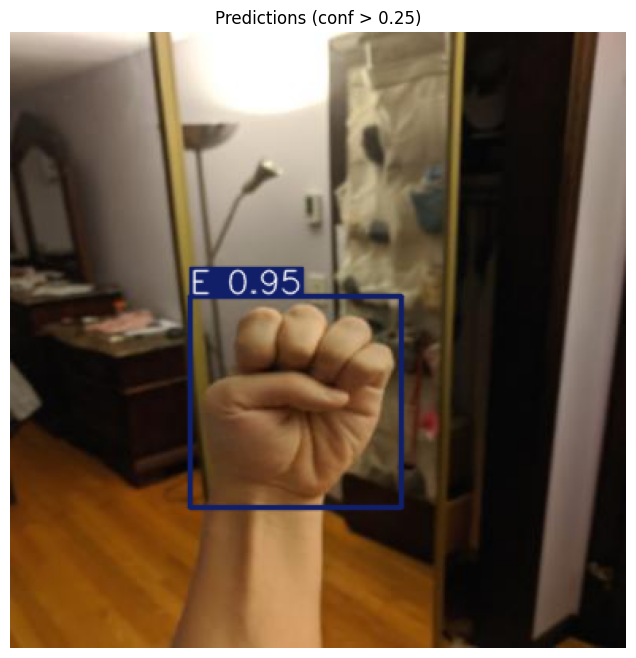

Detection 1: E (confidence: 0.952)


In [16]:
def predict_single_image(model, image_path, conf_threshold=0.25):
    """Make prediction on a single image."""
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        save=False,
        show=False
    )

    # Display results
    for r in results:
        # Plot results
        im_array = r.plot()
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Predictions (conf > {conf_threshold})')
        plt.show()

        # Print detection info
        if len(r.boxes) > 0:
            for i, box in enumerate(r.boxes):
                class_id = int(box.cls[0])
                confidence = float(box.conf[0])
                class_name = CLASS_NAMES[class_id] if class_id < len(CLASS_NAMES) else f"Class_{class_id}"
                print(f"Detection {i+1}: {class_name} (confidence: {confidence:.3f})")
        else:
            print("No detections found")

# Test prediction on a sample image
test_images = os.listdir(os.path.join(OUTPUT_PATH, 'test', 'images'))
if test_images:
    sample_image = os.path.join(OUTPUT_PATH, 'test', 'images', test_images[0])
    print(f"Testing prediction on: {sample_image}")
    predict_single_image(model, sample_image)

In [17]:
print("="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Original dataset: /data/YOLO-Bulk")
print(f"Dataset split: {OUTPUT_PATH}")
print(f"Class names loaded from: /data/YOLO-Bulk/data.yaml")
print(f"Model trained for {EPOCHS} epochs")

# Trained model yolo_training/custom_model/weights/best.pt
# Original Dataset: /data/YOLO-Bulk

TRAINING SUMMARY
Original dataset: /data/YOLO-Bulk
Dataset split: yolo_dataset_split
Class names loaded from: /data/YOLO-Bulk/data.yaml
Model trained for 500 epochs
